In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import math
import json
import random
from copy import deepcopy

from scipy.stats import norm
from collections import Counter
from collections import OrderedDict, defaultdict


import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

# Gaussian weights

Instead of having a separate copy of weights for each node we now have a "master_weights" matrix and each node is going to use a subset of that matrix

In [2]:
def node_to_idxs(node, N):
    return node // N, node % N

In [14]:
def make_master_weights(N,locality):
    rv = norm(loc=0, scale=locality)
    x = np.linspace(-1, 1, N * 2+1) # size is twice as big because we are going to use NxN subsets of it
    p = rv.pdf(x) # make marginal gaussians
    X, Y = np.meshgrid(p, p) # use numpy magic to make them of the right shapes before combining them
    w = X * Y # compute the 2D gaussian by multiplying the marginals together
    w /= w.sum()
    return w

Let's test this "master weights" thing to check it works

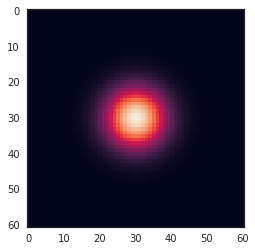

In [4]:
N = 30
locality = 0.2
W = make_master_weights(N=N,locality=locality)
plt.imshow(W)

So far so good, now let's take subsets of each for each node.
We will see the gaussian "pimple" move around as the target node changes

In [15]:
def get_subset(W, node,N):
    assert 0 <= node and node < N*N, f"Node index out of bounds: {node}"
    i,j = node_to_idxs(node,N) # convert node index to row,col coordinates
    subset = W[N-i:N-i+N,N-j:N-j+N] # extract a subset of the master_weights
    return np.copy(subset) # make a copy to make sure subsequent manipulations don't affect the master

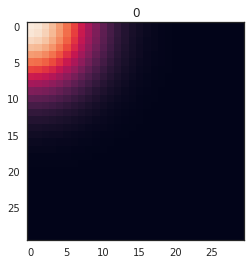

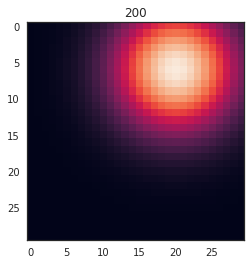

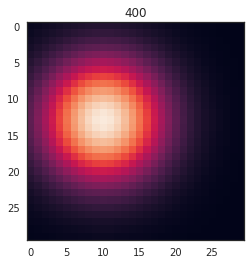

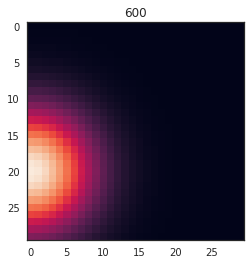

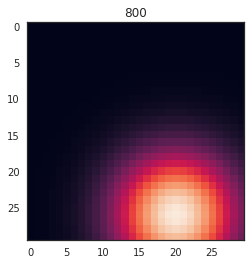

In [16]:
for node in np.arange(0,N*N,200):
    subset = get_subset(W,node,N)    
    plt.imshow(subset)
    plt.title(node)
    plt.show()

Ok, the weights look good. Before we can use them to sample from an hypothetical node we need to remove existing edges.
We are going to make dummy adjacency list to simulate this scenario.

In [26]:
def compute_gaussian_weights(W,node,adjL):
    tmp,N = W.shape
    tmp,N = tmp//2, N//2 # recover side-len from the weigths matrix, yeah, I did't want to have an extra parameter going around
    assert tmp == N, f"Weights have not the expected shape: Expected ({N},{N}), got ({tmp},{N})"
    gauss = get_subset(W,node,N) # get the appropiate subset in the manner we have shown above
    i,j = node_to_idxs(node,N) # zero the node coords to avoid self loops
    gauss[i][j] = 0
    for neigh in adjL[node]: # go through the neighs in the adjlist and zero them
        i,j = node_to_idxs(neigh,N)
        gauss[i][j] = 0
    gauss = gauss / gauss.sum() # normalize everything to make sure we have probabilities
    return gauss.flatten() # flatten them to use with np.random.choice

In [27]:
node = 43
dummy_adjL = {43:set([2,45,39,70,100,250])} # edge 43 is connected to some random nodes
dummy_adjL

{43: {2, 39, 45, 70, 100, 250}}

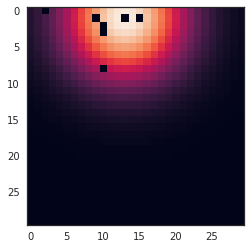

In [28]:
weights = compute_gaussian_weights(W,node,dummy_adjL)

plt.imshow(weights.reshape((N,N))) # notice the black dots where edges exist already

# Sampling

We are now ready to use the weights to sample new edges

In [52]:
# Let's redefine our paramters to have everything in one place
N = 30
node = N * (N - 1) // 2  # pick a node in the center
locality = 0.2
W = make_master_weights(N=N,locality=locality)
dummy_adjL = {node:set([node -2*N, node + 2*N, node + 2, node -2])} # add edges in a cross pattern
weights = sample_gaussian_weights(W,node,dummy_adjL)
num_points = N ** 2
nodes = np.arange(N * N)

Test single samples, we should see a noisy gaussian structure

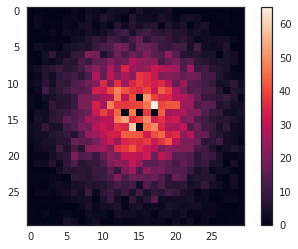

In [53]:
nodes = np.arange(N * N)
samples = [
    np.random.choice(nodes, p=weights, replace=False, size=1)[0]
    for _ in range(10000)
]

# How many times each node has been picked?
samples = Counter(samples).most_common()

results = np.zeros((N, N))
for coord, count in samples:
    # turn nodes id into coordinates for plotting
    x, y = coord // N, coord % N
    results[x][y] = count
plt.imshow(results)
plt.colorbar()

We can see that patern of empty dots around the center node we are sampling from. The method seems to work.